In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple
from CNN_helper_function import get_labels, eval_model

warnings.filterwarnings('ignore')

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D

from tensorflow.keras.models import load_model

print(f"Tensorflow Version: {tf.__version__}")

# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

seed = 42
tf.random.set_seed(seed)

2025-02-02 17:27:00.999517: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-02 17:27:01.046988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-02 17:27:01.047033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-02 17:27:01.048267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 17:27:01.056454: I tensorflow/core/platform/cpu_feature_guar

Tensorflow Version: 2.15.0


2025-02-02 17:27:05.485678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 17:27:05.546434: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 17:27:05.547011: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 19675 files belonging to 2 classes.


2025-02-02 17:27:08.631288: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 17:27:08.631584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 17:27:08.631730: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

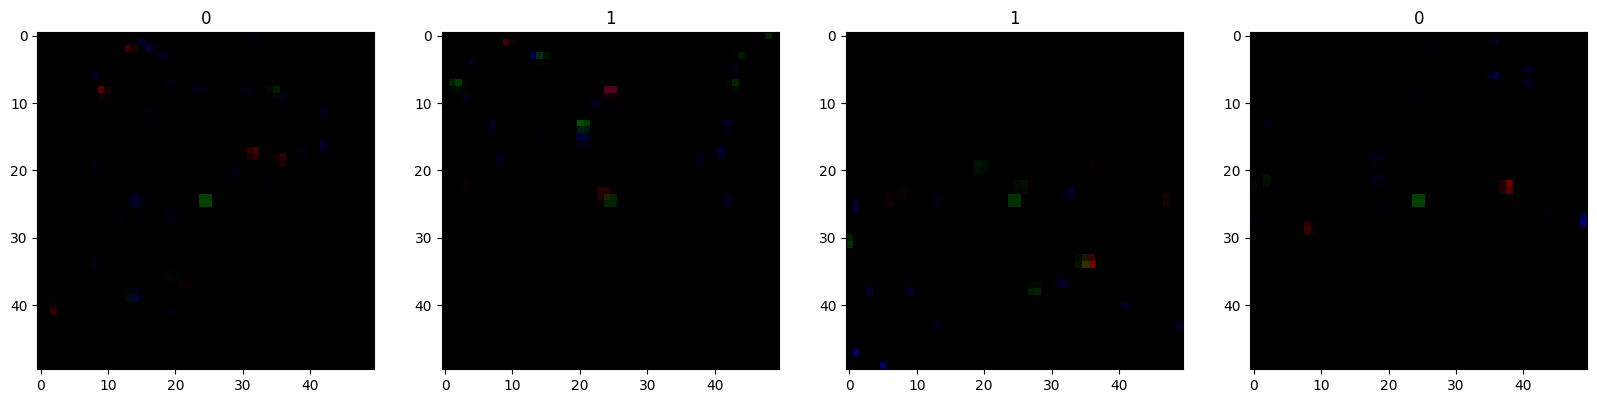

In [2]:
data_dir = '/teamspace/studios/this_studio/all/EFlow Images/rgb_images_data'

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   seed=seed,
                                                   batch_size = 200,
                                                   image_size = (50,50))

scaled_data = data.map(lambda x, y: (x/255, y))

data_iterator = scaled_data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [3]:
train_size = int(len(data)*.7) #70% of total batches as training data
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [4]:
model4 = Sequential()

model4.add(Conv2D(128, (5,5), 1, padding = 'same', activation='relu', input_shape=(50,50,3)))
model4.add(Conv2D(64, (3,3), 1, activation='relu'))
model4.add(AveragePooling2D(pool_size = (2,2),strides=1)) #2x2 filter

model4.add(Conv2D(64, (3,3), 1, activation='relu'))
model4.add(Conv2D(64, (3,3), 1, activation='relu'))
model4.add(AveragePooling2D(pool_size = (2,2)))

model4.add(Conv2D(32, (3,3), 1, activation='relu'))
model4.add(Conv2D(32, (3,3), 1, activation='relu'))
model4.add(AveragePooling2D(pool_size = (2,2), strides=1,
                        padding='same'))

model4.add(Conv2D(16, (2,2), 1, activation='relu'))
model4.add(Conv2D(16, (2,2), 1, activation='relu'))
model4.add(AveragePooling2D(pool_size = (2,2)))

model4.add(Flatten())

model4.add(Dense(256, activation='relu'))
model4.add(Dense(512, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

In [5]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 128)       9728      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        73792     
                                                                 
 average_pooling2d (Average  (None, 47, 47, 64)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        36928     
                                                                 
 average_pooling2d_1 (Avera  (None, 21, 21, 64)        0         
 gePooling2D)                                           

In [6]:
model4.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

In [7]:
logdir = '/teamspace/studios/this_studio/all/EFlow Images/model_tensorboard_logs/Consecutive_Conv_layers_logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model4.fit(train,
                 epochs = 30,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/30


2025-02-02 17:27:13.902179: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
2025-02-02 17:27:23.344240: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc23c1499a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-02 17:27:23.344282: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-02-02 17:27:23.350663: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738517243.477772   28402 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 [==============================] - 43s 278ms/step - loss: 0.6690 - accuracy: 0.5728 - precision: 0.5879 - recall: 0.4596 - auc: 0.6104 - true_positives: 3141.0000 - false_positives: 2202.0000 - true_negatives: 4764.0000 - false_negatives: 3693.0000 - val_loss: 0.6391 - val_accuracy: 0.6255 - val_precision: 0.7484 - val_recall: 0.4128 - val_auc: 0.6793 - val_true_positives: 809.0000 - val_false_positives: 272.0000 - val_true_negatives: 1568.0000 - val_false_negatives: 1151.0000
Epoch 2/30
69/69 [==============================] - 19s 271ms/step - loss: 0.6312 - accuracy: 0.6507 - precision: 0.7034 - recall: 0.5108 - auc: 0.6918 - true_positives: 3495.0000 - false_positives: 1474.0000 - true_negatives: 5484.0000 - false_negatives: 3347.0000 - val_loss: 0.6119 - val_accuracy: 0.6634 - val_precision: 0.7540 - val_recall: 0.5067 - val_auc: 0.7291 - val_true_positives: 984.0000 - val_false_positives: 321.0000 - val_true_negatives: 1537.0000 - val_false_negatives: 958.0000
Epoch 3/30
69/

In [8]:
#model4.save(os.path.join('EFlow Images','Eflowimageclassifier4.keras'))

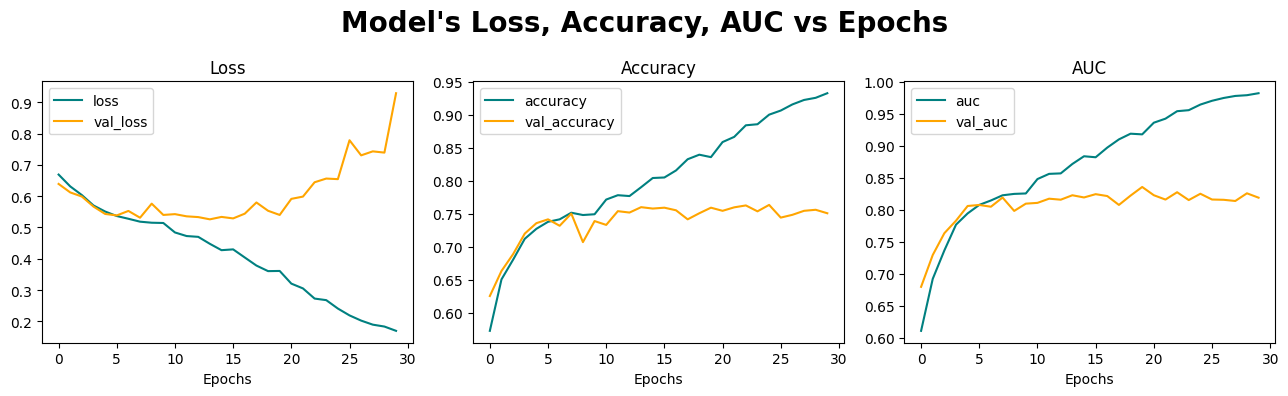

In [9]:
fig, axs = plt.subplots(1, 3, figsize = (13,4))

# Loss Plot
axs[0].plot(hist.history['loss'], color='teal', label='loss')
axs[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Loss')
axs[0].legend(loc="upper left")

# Accuracy Plot
axs[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Accuracy')
axs[1].legend(loc="upper left")

# AUC Plot
axs[2].plot(hist.history['auc'], color='teal', label='auc')
axs[2].plot(hist.history['val_auc'], color='orange', label='val_auc')
axs[2].set_xlabel('Epochs')
axs[2].set_title('AUC')
axs[2].legend(loc="upper left")

plt.suptitle("Model's Loss, Accuracy, AUC vs Epochs", fontsize = 20, fontweight = 'bold')
plt.tight_layout()
# plt.savefig('Consecutive_Conv_layers_trainingMetrics.png', dpi = 300)
plt.show()

In [10]:
test_evaluate = model4.evaluate(test)

9/9 [==============================] - 2s 71ms/step - loss: 1.1574 - accuracy: 0.6989 - precision: 0.7419 - recall: 0.6270 - auc: 0.7599 - true_positives: 575.0000 - false_positives: 200.0000 - true_negatives: 683.0000 - false_negatives: 342.0000


In [11]:
print(f"Best Obtained Loss: {hist.history['loss'][-1]}\n\
Best Obtained Accuracy: {hist.history['accuracy'][-1]*100:.2f}%\n\
Best Obtained Validation Accuracy: {hist.history['val_accuracy'][-1]*100:.2f}%")

Best Obtained Loss: 0.16962707042694092
Best Obtained Accuracy: 93.25%
Best Obtained Validation Accuracy: 75.08%


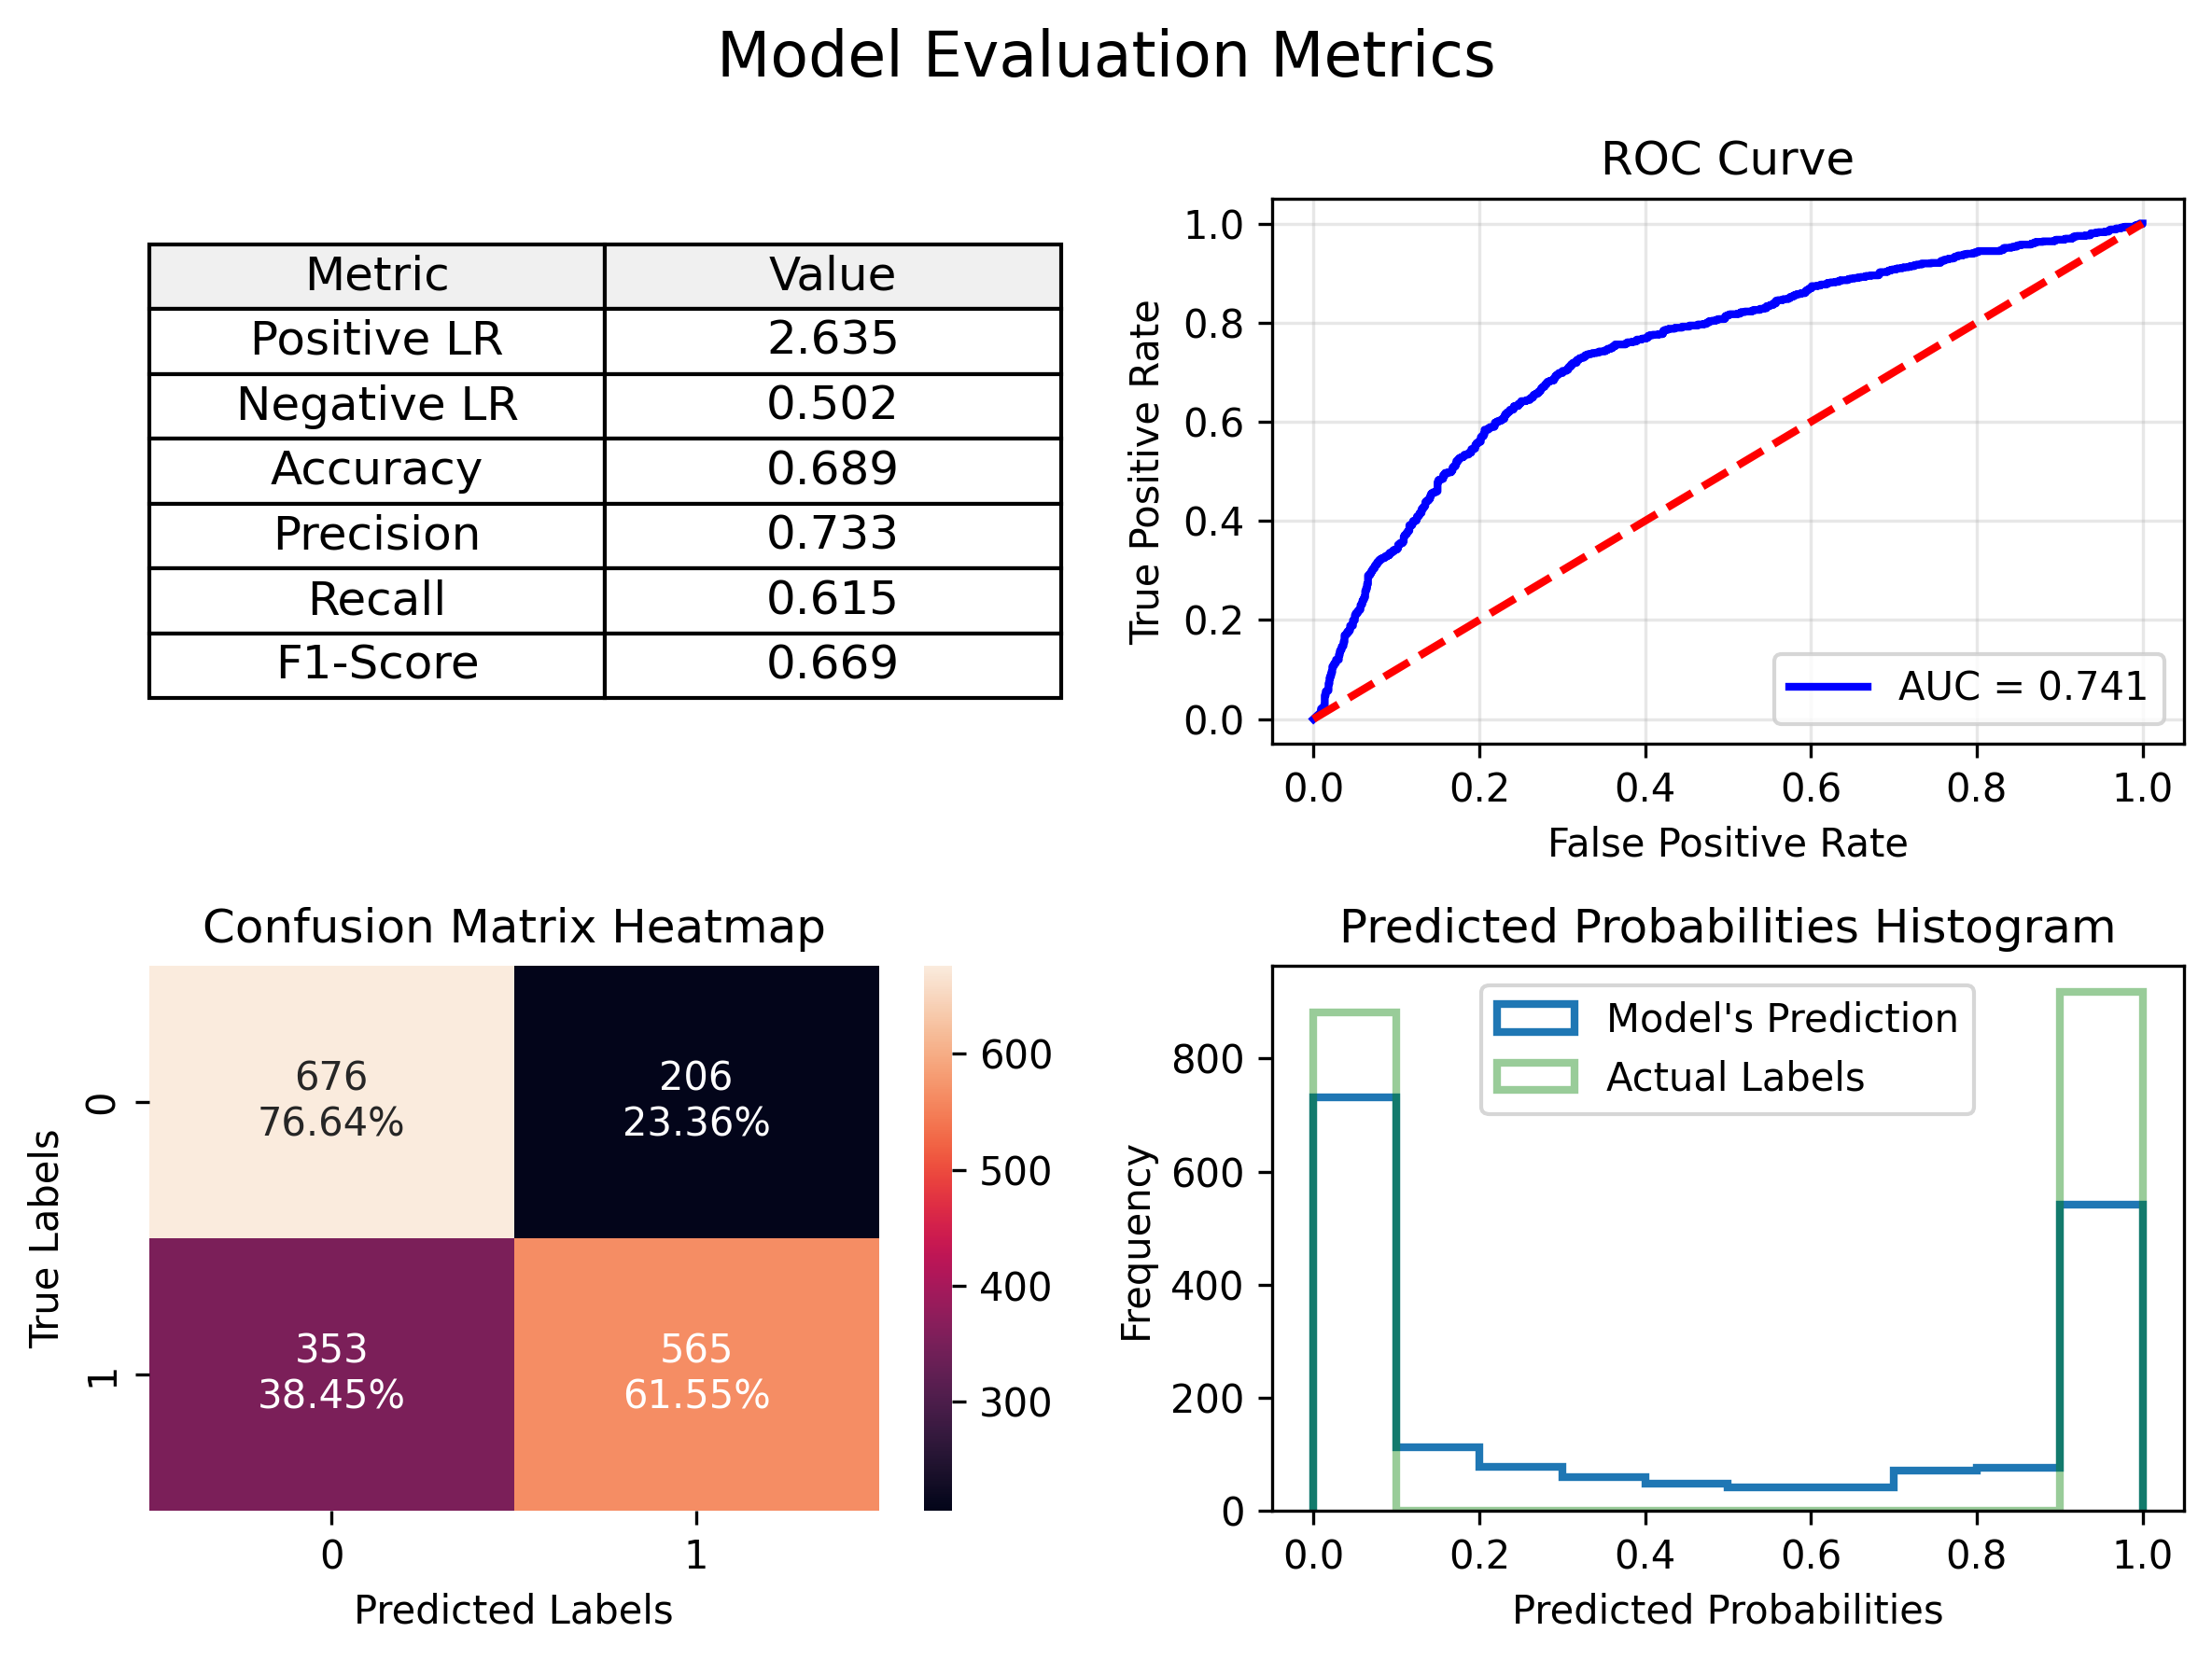

In [13]:
y_test_true, y_test_pred_prob = get_labels(model4, test)
y_test_pred_label = [1 if (y_pred >= 0.5) else 0 for y_pred in y_test_pred_prob]
eval_model(y_test_true, y_test_pred_prob, y_test_pred_label, save_fig = False, save_fig_path = 'Consecutive_Conv_layers_Metrics.png')